# Multi-Class Tabular Model for Durum Wheat Identification Using Python and XGBoost
### David Lowe
### April 28, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Durum Wheat Identification dataset is a multi-class modeling situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: Wheat is the main ingredient of most common food products in many people's daily lives. Obtaining good quality wheat kernels is an essential matter for food supplies. In this study, the research team attempted to examine and classify type-1252 durum wheat kernels to obtain top-quality crops based on their vitreousness. The researchers used a total of 236 morphological, color, wavelet, and gaborlet features to classify durum wheat kernels and foreign objects by training several Artificial Neural Networks (ANNs) with different amounts of elements based on the feature rank list obtained with the ANOVA test.

ANALYSIS: The performance of the preliminary XGBoost model achieved an accuracy benchmark of 99.30%. After a series of tuning trials, the final model processed the training dataset with an accuracy score of 99.60%. When we processed the test dataset with the final model, the model achieved an accuracy score of 99.55%.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Durum Wheat Dataset

Dataset ML Model: Multi-Class classification with numerical features

Dataset Reference: https://www.muratkoklu.com/datasets/

One source of potential performance benchmarks: https://doi.org/10.1016/j.compag.2019.105016

## Task 1 - Prepare Environment

In [1]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Sun Apr 24 19:53:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Retrieve the memory configuration
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 13.6 gigabytes of available RAM



In [3]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5

# Set default modeling scoring metric
SCORING_METRIC = 'accuracy'

# Define the directory locations and file names
TRAIN_DATASET = 'Durum_Wheat_Features.csv'

In [7]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [8]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [9]:
# Clean up the old files and download directories before receiving new ones
# !rm Durum_Wheat_Features.csv

In [10]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/muratkoklu-durum-wheat-dataset/Durum_Wheat_Features.csv

--2022-04-24 19:53:59--  https://dainesanalytics.com/datasets/muratkoklu-durum-wheat-dataset/Durum_Wheat_Features.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 65.9.82.36, 65.9.82.122, 65.9.82.12, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|65.9.82.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25151696 (24M) [text/csv]
Saving to: ‘Durum_Wheat_Features.csv’

Durum_Wheat_Feature 100%[===================>]  23.99M  90.5MB/s    in 0.3s    

2022-04-24 19:54:00 (90.5 MB/s) - ‘Durum_Wheat_Features.csv’ saved [25151696/25151696]



In [11]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head(10))

     Target  AREA   MAJORAXIS  MINORAXIS  ECCENTRICITY     EQDIASQ  \
0  Vitreous   168  109.576157  39.396721      0.973060  213.904236   
1  Vitreous   162  105.584457  43.366894      0.964173  206.264801   
2  Vitreous   145   97.360207  35.532028      0.903072  184.619720   
3  Vitreous   178  104.080582  49.040062      1.272657  226.636627   
4  Vitreous   187  103.716667  40.885876     -1.469139  238.095779   
5  Vitreous   174  102.022720  41.859669      1.318893  221.543671   
6  Vitreous   181  102.592011  48.163528     -0.193211  230.456345   
7  Vitreous   182  109.267799  50.412266      0.413012  231.729584   
8  Vitreous   189  112.180267  43.990417      0.310826  240.642258   
9  Vitreous   189  107.650711  45.974075      0.060356  240.642258   

    PERIMETER  SOLIDITY  ROUNDNESS  SHAPEFACTOR  ...  Gabor_Y9(XYZ)  \
0  202.794052  0.087454   0.017815     0.051334  ...       1.187631   
1  194.794052  0.081901   0.018502     0.053650  ...       2.437782   
2  177.722961  0

In [12]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 237 columns):
 #    Column           Dtype  
---   ------           -----  
 0    Target           object 
 1    AREA             int64  
 2    MAJORAXIS        float64
 3    MINORAXIS        float64
 4    ECCENTRICITY     float64
 5    EQDIASQ          float64
 6    PERIMETER        float64
 7    SOLIDITY         float64
 8    ROUNDNESS        float64
 9    SHAPEFACTOR      float64
 10   COMPACTNESS      float64
 11   EXTENT           float64
 12   mean_R           float64
 13   mean_G           float64
 14   mean_B           float64
 15   StdDev_R         float64
 16   StdDev_G         float64
 17   StdDev_B         float64
 18   skew_R           float64
 19   skew_G           float64
 20   skew_B           float64
 21   kurtosis_R       float64
 22   kurtosis_G       float64
 23   kurtosis_B       float64
 24   entropy_R        float64
 25   entropy_G        float64
 26   entropy_B        f

In [13]:
print(df_dataset_import.describe())

              AREA    MAJORAXIS    MINORAXIS  ECCENTRICITY      EQDIASQ  \
count  9000.000000  9000.000000  9000.000000   9000.000000  9000.000000   
mean    161.262333    94.163920    42.239846      0.235671   205.325572   
std      37.873600    21.715552     8.702915      0.939590    48.222162   
min      32.000000    16.656845    14.979588     -1.570735    40.743664   
25%     150.000000    87.226625    37.874992     -0.506708   190.985931   
50%     166.000000    98.461807    43.864449      0.500317   211.357758   
75%     178.000000   105.031216    48.182106      1.014076   226.636627   
max     382.000000   201.982666    61.994606      1.570701   486.377472   

         PERIMETER     SOLIDITY    ROUNDNESS  SHAPEFACTOR  COMPACTNESS  ...  \
count  9000.000000  9000.000000  9000.000000  9000.000000  9000.000000  ...   
mean    180.663418     0.098197     0.025585     0.067205     0.156987  ...   
std      41.280202     0.027293     0.013833     0.027619     0.030664  ...   
min     

In [14]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Target           0
AREA             0
MAJORAXIS        0
MINORAXIS        0
ECCENTRICITY     0
                ..
Gabor_Z5(XYZ)    0
Gabor_Z6(XYZ)    0
Gabor_Z7(XYZ)    0
Gabor_Z8(XYZ)    0
Gabor_Z9(XYZ)    0
Length: 237, dtype: int64
Total number of NaN in the dataframe:  0


In [15]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('Target').size())

Target
Foreign     3000
Starchy     3000
Vitreous    3000
dtype: int64


### 1.d) Data Cleaning

In [16]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'Target': 'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

     target  AREA   MAJORAXIS  MINORAXIS  ECCENTRICITY     EQDIASQ  \
0  Vitreous   168  109.576157  39.396721      0.973060  213.904236   
1  Vitreous   162  105.584457  43.366894      0.964173  206.264801   
2  Vitreous   145   97.360207  35.532028      0.903072  184.619720   
3  Vitreous   178  104.080582  49.040062      1.272657  226.636627   
4  Vitreous   187  103.716667  40.885876     -1.469139  238.095779   

    PERIMETER  SOLIDITY  ROUNDNESS  SHAPEFACTOR  ...  Gabor_Y9(XYZ)  \
0  202.794052  0.087454   0.017815     0.051334  ...       1.187631   
1  194.794052  0.081901   0.018502     0.053650  ...       2.437782   
2  177.722961  0.096026   0.019477     0.057689  ...       0.527286   
3  202.509750  0.080507   0.020921     0.054543  ...       2.277434   
4  198.811233  0.097650   0.022134     0.059452  ...       2.337524   

   Gabor_Z1(XYZ)  Gabor_Z2(XYZ)  Gabor_Z3(XYZ)  Gabor_Z4(XYZ)  Gabor_Z5(XYZ)  \
0       0.003489       0.013901       0.031153       0.003591       0.01

In [17]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 237 columns):
 #    Column           Dtype  
---   ------           -----  
 0    target           object 
 1    AREA             int64  
 2    MAJORAXIS        float64
 3    MINORAXIS        float64
 4    ECCENTRICITY     float64
 5    EQDIASQ          float64
 6    PERIMETER        float64
 7    SOLIDITY         float64
 8    ROUNDNESS        float64
 9    SHAPEFACTOR      float64
 10   COMPACTNESS      float64
 11   EXTENT           float64
 12   mean_R           float64
 13   mean_G           float64
 14   mean_B           float64
 15   StdDev_R         float64
 16   StdDev_G         float64
 17   StdDev_B         float64
 18   skew_R           float64
 19   skew_G           float64
 20   skew_B           float64
 21   kurtosis_R       float64
 22   kurtosis_G       float64
 23   kurtosis_B       float64
 24   entropy_R        float64
 25   entropy_G        float64
 26   entropy_B        f

In [18]:
print(df_dataset_import.describe())

              AREA    MAJORAXIS    MINORAXIS  ECCENTRICITY      EQDIASQ  \
count  9000.000000  9000.000000  9000.000000   9000.000000  9000.000000   
mean    161.262333    94.163920    42.239846      0.235671   205.325572   
std      37.873600    21.715552     8.702915      0.939590    48.222162   
min      32.000000    16.656845    14.979588     -1.570735    40.743664   
25%     150.000000    87.226625    37.874992     -0.506708   190.985931   
50%     166.000000    98.461807    43.864449      0.500317   211.357758   
75%     178.000000   105.031216    48.182106      1.014076   226.636627   
max     382.000000   201.982666    61.994606      1.570701   486.377472   

         PERIMETER     SOLIDITY    ROUNDNESS  SHAPEFACTOR  COMPACTNESS  ...  \
count  9000.000000  9000.000000  9000.000000  9000.000000  9000.000000  ...   
mean    180.663418     0.098197     0.025585     0.067205     0.156987  ...   
std      41.280202     0.027293     0.013833     0.027619     0.030664  ...   
min     

In [19]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

target           0
AREA             0
MAJORAXIS        0
MINORAXIS        0
ECCENTRICITY     0
                ..
Gabor_Z5(XYZ)    0
Gabor_Z6(XYZ)    0
Gabor_Z7(XYZ)    0
Gabor_Z8(XYZ)    0
Gabor_Z9(XYZ)    0
Length: 237, dtype: int64
Total number of NaN in the dataframe:  0


In [20]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
Foreign     3000
Starchy     3000
Vitreous    3000
dtype: int64


### 1.e) Splitting Data into Sets

In [21]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (9000, 237) df_features_import.shape: (9000, 236) df_target_import.shape: (9000,)


In [22]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                                                        stratify=df_target_import)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (8100, 236) df_target_train.shape: (8100,)
df_features_test.shape: (900, 236) df_target_test.shape: (900,)


### 1.f) Set up the parameters for data visualization

In [23]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [24]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [25]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

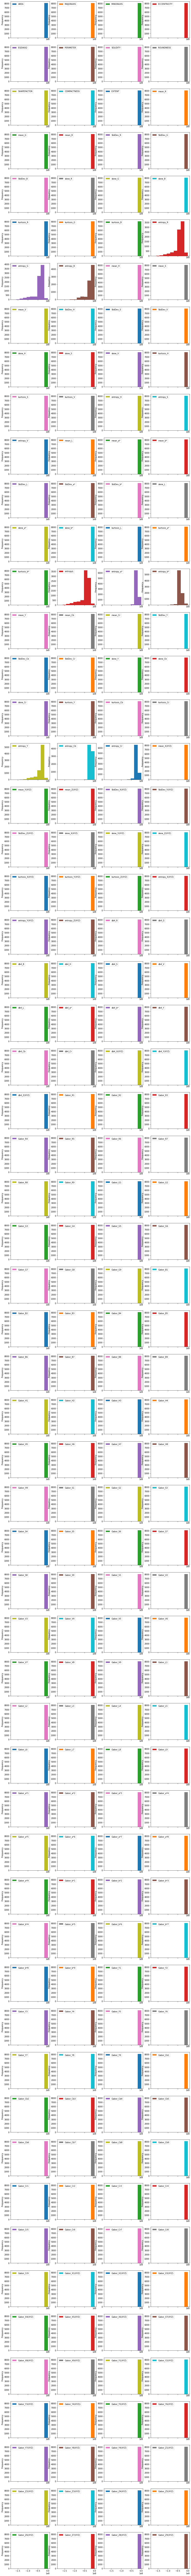

In [26]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

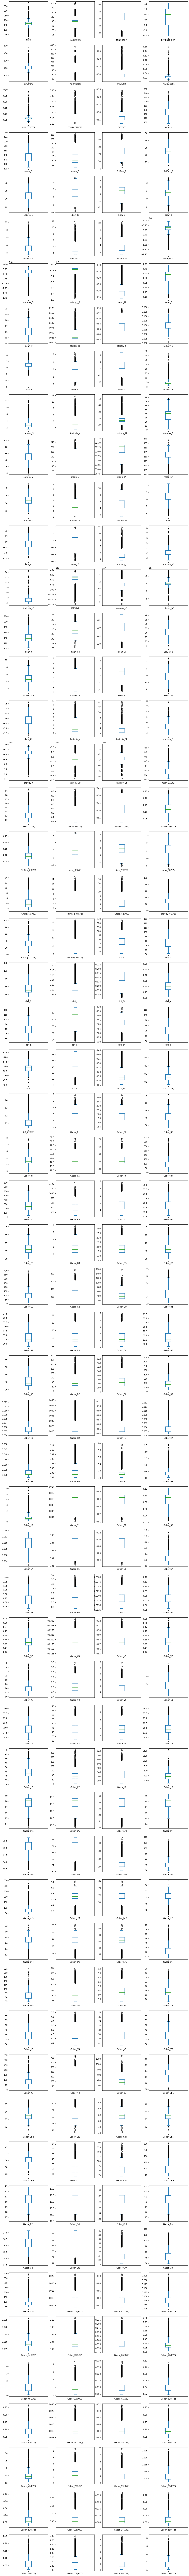

In [27]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [28]:
# # Correlation matrix
# fig = plt.figure(figsize=(20, 20))
# correlations = df_features_train.corr(method='pearson')
# sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
# plt.show()

In [29]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [30]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [31]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 236
Number of categorical columns: 0
Total number of columns in the feature dataframe: 236


In [32]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (8100, 236) to array_features_train.shape: (8100, 236)


### 3.b) Training Data Balancing

In [33]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [34]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [35]:
# Finalize the training dataset for the modeling activities
array_features_train = preprocessor.fit_transform(df_features_train)
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (8100, 236) array_target_train.shape: (8100,)


In [36]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [37]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [38]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [39]:
train_models.append(('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softmax', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')))

In [40]:
# Generate model in turn
for name, model in train_models:
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
    start_time_module = datetime.now()
    kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
    cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
    train_results.append(cv_results)
    train_model_names.append(name)
    train_metrics.append(cv_results.mean())
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    print(model)
    print ('Model training time:', (datetime.now() - start_time_module), '\n')
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: 0.993086 (0.001197)
XGBClassifier(eval_metric='mlogloss', objective='multi:softmax',
              random_state=888, tree_method='gpu_hist',
              use_label_encoder=False)
Model training time: 0:00:04.212979 

Average metrics (accuracy) from all models: 0.9930864197530864
Total training time for all models: 0:00:04.247663


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.2s finished


### 4.b) Algorithm Tuning

In [41]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [42]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100, 501, 100),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([1, 2, 3]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best: 0.996049 using {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.993086 (0.001197) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.996049 (0.000494) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.995926 (0.000494) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.995926 (0.000494) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
0.995926 (0.000837) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.993086 (0.001429) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
0.995679 (0.000873) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
0.995926 (0.000837) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}
0.995679 (0.000873) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 400}
0.995802 (0.000720) with: {'max_depth': 3, 'min_child_weight': 2, 'n_esti

In [43]:
BEST_MAX_DEPTH = grid_result1.best_params_['max_depth']
BEST_MIN_CHILD_WEIGHT = grid_result1.best_params_['min_child_weight']
BEST_N_ESTIMATORS = grid_result1.best_params_['n_estimators']
print('Best max_depth parameter:', BEST_MAX_DEPTH)
print('Best min_child_weight parameter:', BEST_MIN_CHILD_WEIGHT)
print('Best n_estimators parameter:', BEST_N_ESTIMATORS)

Best max_depth parameter: 3
Best min_child_weight parameter: 1
Best n_estimators parameter: 200


In [44]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]),
                  colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best: 0.996049 using {'colsample_bytree': 1.0, 'subsample': 1.0}
0.994691 (0.001210) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.995062 (0.000873) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.995062 (0.000676) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.995802 (0.000720) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.994815 (0.001003) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.994815 (0.001003) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.995062 (0.000873) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.995432 (0.000837) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.995185 (0.000605) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.994815 (0.000494) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.995432 (0.000494) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.995556 (0.000720) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.995309 (0.000924) with: {'colsam

In [45]:
BEST_COLSAMPLE_BYTREE = grid_result2.best_params_['colsample_bytree']
BEST_SUBSAMPLE = grid_result2.best_params_['subsample']
print('Best colsample_bytree parameter:', BEST_COLSAMPLE_BYTREE)
print('Best subsample parameter:', BEST_SUBSAMPLE)

Best colsample_bytree parameter: 1.0
Best subsample parameter: 1.0


### 4.c) Compare Algorithms After Tuning

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


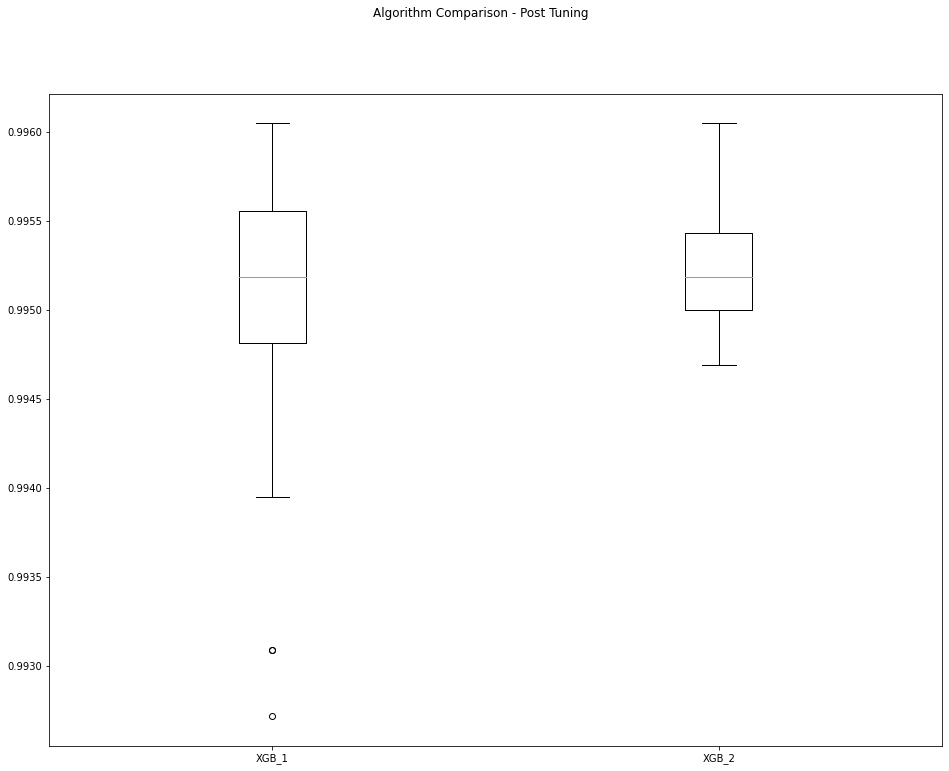

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [47]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [48]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [49]:
final_model = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            colsample_bytree=BEST_COLSAMPLE_BYTREE, subsample=BEST_SUBSAMPLE, random_state=RNG_SEED,
                            n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
final_model.fit(array_features_train, array_target_train)
print(final_model)

XGBClassifier(colsample_bytree=1.0, eval_metric='mlogloss', n_estimators=200,
              objective='multi:softprob', random_state=888, subsample=1.0,
              tree_method='gpu_hist', use_label_encoder=False)


### 5.b) Load Test Dataset and Make Predictions

In [50]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
array_target_test = label_encoder.transform(df_target_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (900, 236) to array_features_test.shape: (900, 236)


In [51]:
# Make batched predictions
test_predictions =  final_model.predict(array_features_test)
print(test_predictions)

[2 0 0 0 1 2 1 2 2 0 1 0 2 2 0 2 2 1 2 0 2 0 1 2 2 2 2 1 2 2 1 2 1 0 0 0 2
 0 0 1 0 2 2 0 2 0 1 2 1 0 0 1 1 1 2 1 1 0 0 0 1 1 0 0 1 0 0 1 2 2 2 2 2 2
 1 0 0 0 2 0 1 2 0 1 0 0 1 0 1 0 0 1 2 2 1 2 1 1 1 0 1 1 1 2 1 2 1 0 2 2 0
 1 1 1 2 2 0 0 0 1 2 1 1 1 0 1 2 0 2 2 2 1 1 2 2 2 0 0 1 2 0 2 1 2 0 0 1 0
 0 2 0 1 0 0 1 0 0 2 1 2 0 0 2 1 0 0 2 2 2 0 0 0 2 1 0 2 1 2 2 1 2 0 0 0 1
 0 0 1 1 2 1 2 2 0 1 2 2 2 1 1 1 1 2 2 2 1 0 2 1 1 1 1 2 0 2 2 1 1 0 1 0 2
 0 2 0 2 0 2 1 1 2 0 2 1 0 1 0 0 0 1 2 2 0 2 0 0 0 0 1 0 1 2 0 1 0 2 0 0 1
 1 2 1 1 2 2 1 0 0 0 2 2 1 0 1 1 1 1 1 2 2 1 0 1 0 1 2 1 1 1 0 0 2 1 0 2 2
 1 0 2 2 0 0 2 1 2 0 0 1 1 0 0 1 0 2 2 2 0 1 2 1 1 0 0 1 0 0 1 1 2 0 1 2 2
 2 1 2 2 1 1 2 0 1 0 2 0 1 1 2 0 2 1 2 1 1 0 1 0 2 2 0 1 0 1 1 1 1 1 2 2 1
 1 0 0 2 1 0 1 1 2 2 0 0 2 1 2 1 1 1 2 2 1 1 2 2 2 2 1 2 2 0 0 1 2 2 2 2 2
 2 1 1 0 0 2 1 0 1 2 1 0 0 2 2 0 0 0 1 1 1 1 1 1 0 1 1 2 2 1 0 1 2 0 2 2 1
 0 0 0 1 2 1 2 2 1 2 2 1 2 2 2 0 2 1 1 0 1 2 2 2 1 2 2 1 2 0 0 0 2 2 0 1 2
 2 2 2 1 1 2 0 0 1 2 2 2 

In [52]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print(confusion_matrix(array_target_test, test_predictions))
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.9955555555555555
[[300   0   0]
 [  0 296   4]
 [  0   0 300]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      0.99      0.99       300
           2       0.99      1.00      0.99       300

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



In [53]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [54]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:11:01.988380
